> **Beginners Guide to Text Generation using GRUs**

Text Generation is a type of Language Modelling problem. Language Modelling is the core problem for a number of of natural language processing tasks such as speech to text, conversational system, and text summarization. A trained language model learns the likelihood of occurrence of a word based on the previous sequence of words used in the text. Language models can be operated at character level, n-gram level, sentence level or even paragraph level. In this notebook, I will explain how to create a language model for generating natural language text by implement and training state-of-the-art Recurrent Neural Network.

**Import the libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import string
import unidecode
import random
import torch

In [2]:
# Check if GPU is available
train_on_gpu = torch.cuda.is_available()
if(train_on_gpu):
    print('Training on GPU!')
else: 
    print('No GPU available, training on CPU; consider making n_epochs very small.')

Training on GPU!


**Load the dataset**

In [3]:
train_df = pd.read_csv('../input/train.csv')
author = train_df[train_df['author'] == 'EAP']["text"]
author[:5]

0    This process, however, afforded me no means of...
2    In his left hand was a gold snuff box, from wh...
6    The astronomer, perhaps, at this point, took r...
7          The surcingle hung in ribands from my body.
8    I knew that you could not say to yourself 'ste...
Name: text, dtype: object

**Dataset cleaning**

In [4]:
text = list(author[:100])
def joinStrings(text):
    return ' '.join(string for string in text)
text = joinStrings(text)
# text = [item for sublist in author[:5].values for item in sublist]
len(text.split())

2802

In [5]:
stop = set(nltk.corpus.stopwords.words('english'))
exclude = set(string.punctuation) 
lemma = nltk.stem.wordnet.WordNetLemmatizer()
def clean(doc):
        stop_free = " ".join([i for i in doc.split() if i not in stop])
        punc_free = "".join(ch for ch in stop_free if ch not in exclude)
        normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
        return normalized
test_sentence = clean(text).lower().split()

> **N-Gram Language Modeling**

Recall that in an n-gram language model, given a sequence of words w, we want to compute.
                                      * P(wi|wi−1,wi−2,…,wi−n+1)                                                     
Where wi is the ith word of the sequence.                                                                              here we will take n=2.

In [6]:
trigrams = [([test_sentence[i], test_sentence[i + 1]], test_sentence[i + 2])
            for i in range(len(test_sentence) - 2)]
chunk_len=len(trigrams)
print(trigrams[:3])

[(['this', 'process'], 'however'), (['process', 'however'], 'afforded'), (['however', 'afforded'], 'mean')]


In [7]:
vocab = set(test_sentence)
voc_len=len(vocab)
word_to_ix = {word: i for i, word in enumerate(vocab)}


In [8]:
inp=[]
tar=[]
for context, target in trigrams:
        context_idxs = torch.tensor([word_to_ix[w] for w in context], dtype=torch.long)
        inp.append(context_idxs)
        targ = torch.tensor([word_to_ix[target]], dtype=torch.long)
        tar.append(targ)

**GRU model for Text Generation**

In [9]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size*2, hidden_size, n_layers,batch_first=True,
                          bidirectional=False)
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.gru(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))

In [10]:
def train(inp, target):
    hidden = decoder.init_hidden().cuda()
    decoder.zero_grad()
    loss = 0
    
    for c in range(chunk_len):
        output, hidden = decoder(inp[c].cuda(), hidden)
        loss += criterion(output, target[c].cuda())

    loss.backward()
    decoder_optimizer.step()

    return loss.data.item() / chunk_len

In [11]:
import time, math

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [12]:
n_epochs = 300
print_every = 100
plot_every = 10
hidden_size = 100
n_layers = 1
lr = 0.015

decoder = RNN(voc_len, hidden_size, voc_len, n_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0
if(train_on_gpu):
    decoder.cuda()
for epoch in range(1, n_epochs + 1):
    loss = train(inp,tar)       
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 50, loss))
#         print(evaluate('ge', 200), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

 30s (100 16%) 0.0001]
 58s (200 33%) 0.0001]
 24s (300 50%) 0.0001]


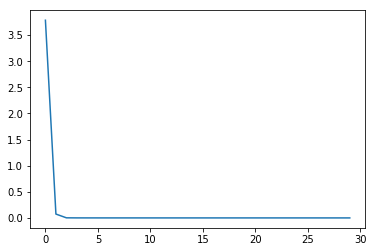

In [13]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

**Generating the text**

In [14]:
def evaluate(prime_str='this process', predict_len=100, temperature=0.8):
    hidden = decoder.init_hidden().cuda()

    for p in range(predict_len):
        
        prime_input = torch.tensor([word_to_ix[w] for w in prime_str.split()], dtype=torch.long).cuda()
        inp = prime_input[-2:] #last two words as input
        output, hidden = decoder(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted word to string and use as next input
        predicted_word = list(word_to_ix.keys())[list(word_to_ix.values()).index(top_i)]
        prime_str += " " + predicted_word
#         inp = torch.tensor(word_to_ix[predicted_word], dtype=torch.long)

    return prime_str

In [15]:
print(evaluate('this process', 40, temperature=1))

this process however afforded mean ascertaining dimension dungeon i might make circuit return point whence i set out without aware fact perfectly uniform seemed wall in left hand gold snuff box which capered hill cutting manner fantastic step took snuff incessantly air


In [16]:
print(evaluate('i might', 30, temperature=1))

i might make circuit return point whence i set out without aware fact perfectly uniform seemed wall in left hand gold snuff box which capered hill cutting manner fantastic step took snuff


> **Improvement Ideas**

As we can see, the model has produced the output which looks fairly fine. The results can be improved further with following points:

* Adding more data
* Fine Tuning the network architecture
* Fine Tuning the network parameters

Thanks for going through the notebook, please upvote if you liked.